# Learning to rank with SVM and Random forrests

In [179]:
import json
import pandas as pd

global_corect_pairs = 0.0
global_invalid_pairs = 0.0
global_correct_weighted_pairs = 0.0
global_invalid_weighted_pairs = 0.0
row_number = 0

df = pd.DataFrame(columns=["query",
    "user_score",
    "elastic_score",
    "rank",
    "members rank mean",
    "members rank median",
    "members system interesting score mean",
    "members system interesting score median",
    "valid members count",
    "invalid members count",
    "valid members ratio",
    "nonavailable members count",
    "nonavailable members ratio",
    "is merged",])

with open("data/relevance-score-11.05.2023.jsonl") as input:
    for row in input:
        row_number += 1
        corect_pairs = 0.0
        invalid_pairs = 0.0
        weighted_correct_pairs = 0.0
        weighted_invalid_pairs = 0.0
        data = json.loads(row.strip())
        key = list(data)[0]
        for idx_1, (key_1, features_1) in enumerate(data[key].items()):
            value_1 = features_1["user_score"]
            df.loc[len(df)] = [key, *features_1.values()]

            for idx_2, (key_2, features_2) in enumerate(data[key].items()):
                value_2 = features_2["user_score"]
                if(idx_1 == idx_2):
                    continue

                if idx_1 < idx_2 and value_1 >= value_2:
                    corect_pairs += 1
                    weighted_correct_pairs += value_1 / 5
                    global_corect_pairs += 1
                else:
                    invalid_pairs += 1
                    weighted_invalid_pairs += value_2 / 5
                    global_invalid_pairs += 1

        if(corect_pairs + invalid_pairs == 0):
            print(f"{key} Zero results")
        else:
            print(f"{key}: %.3f" % (corect_pairs / (corect_pairs + invalid_pairs)))
            if(weighted_correct_pairs + weighted_invalid_pairs > 0):
                print(f"{key} (weighted): %.3f" % (weighted_correct_pairs / (weighted_correct_pairs + weighted_invalid_pairs)))
                global_correct_weighted_pairs += weighted_correct_pairs
                global_invalid_weighted_pairs += weighted_invalid_pairs

    print("Global %.3f weighted %.3f" % ((global_corect_pairs / (global_corect_pairs + global_invalid_pairs)), (global_correct_weighted_pairs / (global_correct_weighted_pairs + global_invalid_weighted_pairs ))))
    print(f"Number of keywords {row_number}")

apple: 0.378
apple (weighted): 0.385
apples: 0.378
apples (weighted): 0.412
bmw: 0.300
bmw (weighted): 0.309
hulk: 0.356
hulk (weighted): 0.387
marvel: 0.333
marvel (weighted): 0.355
marvel characters: 0.431
marvel characters (weighted): 0.443
fruit: 0.422
fruit (weighted): 0.444
fruits: 0.292
fruits (weighted): 0.316
britney spears: 0.422
britney spears (weighted): 0.463
bmw car models: 0.233
bmw car models (weighted): 0.262
cars: 0.411
cars (weighted): 0.421
football players: 0.256
football players (weighted): 0.304
cristiano ronaldo: 0.333
cristiano ronaldo (weighted): 0.355
planets: 0.179
planets (weighted): 0.189
countries: 0.347
countries (weighted): 0.375
france: 0.356
france (weighted): 0.409
switzerland: 0.444
switzerland (weighted): 0.449
bmw vehicles: 0.211
bmw vehicles (weighted): 0.238
greek gods: 0.222
greek gods (weighted): 0.242
zeus: 0.444
zeus (weighted): 0.459
athena: 0.322
athena (weighted): 0.356
fire: 0.403
fire (weighted): 0.441
funny: 0.367
funny (weighted): 0.3

In [180]:
df.describe().apply(lambda s: s.apply('{0:.1f}'.format))

,user_score,elastic_score,rank,members rank mean,members rank median,members system interesting score mean,members system interesting score median,valid members count,invalid members count,valid members ratio,nonavailable members count,nonavailable members ratio
count,1103.0,1103.0,1103.0,1103.0,1103.0,1103.0,1103.0,1103.0,1103.0,1103.0,1103.0,1103.0
mean,2.0,226.5,168786.5,445824.6,202595.3,0.9,0.9,996.1,448.3,0.6,193.9,0.3
std,1.5,20.3,621656.5,1400443.4,1012511.2,0.1,0.1,1946.3,3153.4,0.4,361.3,0.3
min,0.0,132.4,54.0,488.0,215.0,0.3,0.2,1.0,1.0,0.0,2.0,0.0
25%,1.0,213.7,13464.5,51221.5,7631.5,0.8,0.9,34.0,39.5,0.2,6.0,0.1
50%,1.0,224.9,44130.0,146895.0,24650.0,0.9,0.9,139.0,132.0,0.6,30.0,0.3
75%,3.0,231.9,124902.0,323160.0,93159.0,0.9,0.9,873.0,326.0,0.9,159.5,0.5
max,5.0,380.0,17303937.0,25974102.0,18305608.0,0.9,0.9,16495.0,63960.0,1.0,2112.0,1.0


<Axes: ylabel='Frequency'>

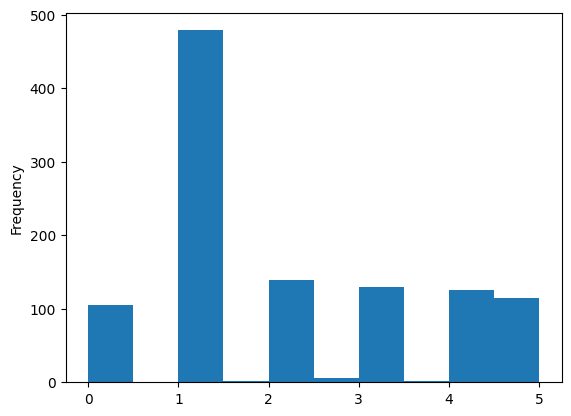

In [181]:
import matplotlib.pyplot as plt

df['user_score'].plot.hist()

In [182]:
from collections import defaultdict
user_rows = []
es_rows = []
rows = []

user_types = set()
es_types = set()

user_lenghts = defaultdict(int)
es_lenghts = defaultdict(int)

for key, features in df.groupby('query'):
    user_score = list(features['user_score'])
    if(len(user_score) != 10):
        continue
    user_lenghts[len(user_score)] += 1
    for v in user_score:
        user_types.add(type(v))

    es_score = list(features['elastic_score'])
    es_lenghts[len(es_score)] += 1
    for v in es_score:
        es_types.add(type(v))

    user_rows.append(user_score)
    es_rows.append(es_score)

print("%i %i %i %i" % (len(user_rows), len(es_rows), len(user_rows[0]), len(es_rows[0])))

104 104 10 10


In [183]:
from sklearn.metrics import ndcg_score
import numpy as np

"%.3f" % ndcg_score(np.asarray(user_rows), np.asarray(es_rows))

'0.875'

In [184]:
#from ir_evaluation.effectiveness import effectiveness
#ir=effectiveness()
#ir.ndcgain()

df['rank_log'] = df['rank'].apply(lambda x : np.log10(x))
df['mrank_mean_log'] = df['members rank mean'].apply(lambda x : np.log10(x))
df['mrank_median_log'] = df['members rank median'].apply(lambda x : np.log10(x))
df['user_binary'] = df['user_score'].apply(lambda x: x == 0)

## File preperation for RankLib

In [185]:
from sklearn.model_selection import train_test_split

#df = df.drop(['user_binary'], axis=1)
#print(df.columns)
df_2 = df.drop(['elastic_score', 'rank', 'members rank mean', 'members rank median'], axis=1)

query = None
query_id = 0



X_train, X_test = train_test_split(
    df_2, test_size=0.2, random_state=0, shuffle=True
)

for dataset, name in [(X_train, "train"), (X_test, "test")]:
    with open(f"data/relevance-score-11.05.2023-{name}.ranklib", "w") as output:
        for row in dataset.iterrows():
            row = row[1]
            if row.values[0] != query:
                query = row.values[0]
                query_id += 1
            
            score = int(row.values[1])
            merged_index = list(row.keys()).index('is merged')
            print(row.keys())
            print(merged_index)
            print(row.keys()[3:merged_index])
            print(row.keys()[merged_index+1:-1])
            print(values)
            joined_lists =  list(row.values[3:merged_index]) + list(row.values[merged_index+1:-1])
            #print(joined_lists)
            values = " ".join([f"{idx+1}:{e}" for idx, e in enumerate(joined_lists)])

            if(row.values[merged_index]):
                values += f" {len(joined_lists)+1}:1"
            else:
                values += f" {len(joined_lists)+1}:0"

            output.write(f"{score} qid:{query_id} {values}\n")
#X = df.drop(['user_binary'], axis=1)
#y = df['user_binary']

#print(X.columns)

Index(['query', 'user_score', 'members system interesting score mean',
       'members system interesting score median', 'valid members count',
       'invalid members count', 'valid members ratio',
       'nonavailable members count', 'nonavailable members ratio', 'is merged',
       'rank_log', 'mrank_mean_log', 'mrank_median_log', 'user_binary'],
      dtype='object')
9
Index(['members system interesting score median', 'valid members count',
       'invalid members count', 'valid members ratio',
       'nonavailable members count', 'nonavailable members ratio'],
      dtype='object')
Index(['rank_log', 'mrank_mean_log', 'mrank_median_log'], dtype='object')
1:0.93 2:6083 3:81 4:0.99 5:193 6:0.03 7:False 8:4.553992193099424 9:4.353743170753935 10:0
Index(['query', 'user_score', 'members system interesting score mean',
       'members system interesting score median', 'valid members count',
       'invalid members count', 'valid members ratio',
       'nonavailable members count', 'non

## Binary classification, 0 user score = filtered class

In [147]:
df_1 = df.drop(['user_score', 'query', 'elastic_score', 'rank', 'members rank mean', 'members rank median'], axis=1).drop_duplicates()

X = df_1.drop(['user_binary'], axis=1)
y = df_1['user_binary']

print(X.columns)

Index(['members system interesting score mean',
       'members system interesting score median', 'valid members count',
       'invalid members count', 'valid members ratio',
       'nonavailable members count', 'nonavailable members ratio', 'is merged',
       'rank_log', 'mrank_mean_log', 'mrank_median_log'],
      dtype='object')


In [148]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, shuffle=True, stratify=y
)

stats = y_train.describe()
print("%.2f" % (float(stats['freq']) / stats['count']))

stats = y_test.describe()
print("%.2f" % (float(stats['freq']) / stats['count']))

#print(y_train.describe())
#print(y_test.describe())

0.89
0.89


In [149]:
X_train

,members system interesting score mean,members system interesting score median,valid members count,invalid members count,valid members ratio,nonavailable members count,nonavailable members ratio,is merged,rank_log,mrank_mean_log,mrank_median_log
920,0.8323,0.9228,648,438,0.60,116,0.27,False,5.280913,5.997548,4.907137
589,0.9274,0.9316,102,5,0.96,13,0.12,False,3.832253,4.615771,2.972203
157,0.8198,0.9217,40,100,0.29,34,0.82,False,5.051662,5.620671,5.274142
298,0.8454,0.9310,691,86,0.89,365,0.53,False,5.325341,6.289962,6.013297
741,0.7836,0.9307,29,628,0.04,20,0.66,False,5.019386,5.225247,4.392134
...,...,...,...,...,...,...,...,...,...,...,...
364,0.7576,0.7785,2616,1321,0.66,26,0.01,False,3.983220,4.215082,3.402605
942,0.9244,0.9314,97,114,0.46,13,0.12,False,3.220108,5.278500,4.457094
644,0.9345,0.9350,148,240,0.38,149,1.00,False,5.106245,7.014214,6.902999
804,0.8773,0.9316,171,566,0.23,70,0.41,False,4.693788,5.227056,4.630916


### Decision tree

In [150]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(criterion="entropy", random_state=0)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [151]:
print(X_train.columns)

Index(['members system interesting score mean',
       'members system interesting score median', 'valid members count',
       'invalid members count', 'valid members ratio',
       'nonavailable members count', 'nonavailable members ratio', 'is merged',
       'rank_log', 'mrank_mean_log', 'mrank_median_log'],
      dtype='object')


In [152]:
from sklearn.metrics import roc_auc_score

y_pred = dt_clf.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred)

print(f"Decision tree AUROC: {100 * auroc:.2f}")

Decision tree AUROC: 68.27


### RandomForrest

In [153]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, criterion="entropy", random_state=0, n_jobs=-1)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred)
print(f"Random Forest AUROC: {100 * auroc:.2f}")

Random Forest AUROC: 81.41


In [162]:
print(rf_clf.predict(X_test))
print(y_test)

[False False False False False False  True False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False Fa

In [155]:
import pickle
from joblib import dump, load

dump(rf_clf, "data/random-forrest.model") 

['data/random-forrest.model']

In [145]:
rf_clf_2 = load('data/random-forrest.model')

y_pred = rf_clf_2.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred)
print(f"Random Forest AUROC: {100 * auroc:.2f}")

Random Forest AUROC: 81.41


In [146]:
print(X_test)

     members system interesting score mean   
957                                 0.9140  \
905                                 0.8907   
862                                 0.9043   
344                                 0.9136   
241                                 0.8540   
..                                     ...   
79                                  0.8494   
833                                 0.8633   
380                                 0.9352   
355                                 0.7877   
794                                 0.9004   

     members system interesting score median  valid members count   
957                                   0.9318                  326  \
905                                   0.9311                 1832   
862                                   0.9307                 2248   
344                                   0.9316                  608   
241                                   0.9313                 2074   
..                               

In [39]:
from sklearn.model_selection import GridSearchCV


cv = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=500, criterion="entropy", random_state=0, n_jobs=-1),
    param_grid={
        "max_features": [0.1, 0.5, 0.7],
        "max_depth": [None, 10, 20],
        "class_weight": [None, {True: 0.5, False: 1}, {True: 0.1, False: 1}, {True: 0.7, False: 1}]
    },
    scoring="roc_auc",
    cv=5,
    verbose=2
)

cv.fit(X_train, y_train)
rf_clf_tuned = cv.best_estimator_

y_pred_rf = rf_clf_tuned.predict_proba(X_test)[:, 1]

print(f"Random Forest tuned with CV AUROC: {100 * roc_auc_score(y_test, y_pred_rf):.2f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END class_weight=None, max_depth=None, max_features=0.1; total time=   2.1s
[CV] END class_weight=None, max_depth=None, max_features=0.1; total time=   0.6s
[CV] END class_weight=None, max_depth=None, max_features=0.1; total time=   0.6s
[CV] END class_weight=None, max_depth=None, max_features=0.1; total time=   0.6s
[CV] END class_weight=None, max_depth=None, max_features=0.1; total time=   0.6s
[CV] END class_weight=None, max_depth=None, max_features=0.5; total time=   0.7s
[CV] END class_weight=None, max_depth=None, max_features=0.5; total time=   0.7s
[CV] END class_weight=None, max_depth=None, max_features=0.5; total time=   0.7s
[CV] END class_weight=None, max_depth=None, max_features=0.5; total time=   0.8s
[CV] END class_weight=None, max_depth=None, max_features=0.5; total time=   0.7s
[CV] END class_weight=None, max_depth=None, max_features=0.7; total time=   0.7s
[CV] END class_weight=None, max_depth=None, max

### SVM

In [100]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=0, probability=True)
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred)
print(f"Random Forest AUROC: {100 * auroc:.2f}")

Random Forest AUROC: 52.91


In [18]:
from sklearn.model_selection import GridSearchCV

cv = GridSearchCV(
    estimator=SVC(random_state=0, probability=True),
    param_grid={
        'C': [0.001, 0.01, 0.1, 1],
              'gamma': [0.01, 0.001, 0.0001],
              'kernel': ['rbf']
    },
    scoring="roc_auc",
    cv=5,
    verbose=2
)

cv.fit(X_train, y_train)
rf_clf_tuned = cv.best_estimator_

y_pred_rf = rf_clf_tuned.predict_proba(X_test)[:, 1]

print(f"SVM tuned with CV AUROC: {100 * roc_auc_score(y_test, y_pred_rf):.2f}")

print(cv.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.1s
[CV] END ..................C=0.001, gamma=0.0001

### LigthGBM

In [96]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(random_state=0, n_jobs=-1)
lgbm_clf.fit(X_train, y_train)

y_pred_lgbm = lgbm_clf.predict_proba(X_test)[:, 1]
print(f"LightGBM AUROC: {100 * roc_auc_score(y_test, y_pred_lgbm):.2f}")

LightGBM AUROC: 75.95


In [99]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

param_grid = {
    "n_estimators": [400, 500, 600],
    "learning_rate": [0.05, 0.1, 0.2],
    "num_leaves": [31, 48, 64],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "subsample": [0.8, 0.9, 1.0],
}

cv = RandomizedSearchCV(
    estimator=LGBMClassifier(random_state=0, n_jobs=-1),
    param_distributions=param_grid,
    scoring="roc_auc",
    n_iter=100,
    cv=5,
    random_state=0
)

cv.fit(X_train, y_train)

lgbm_clf_tuned = cv.best_estimator_
print(cv.best_params_)

y_pred_lightgbm_tuned = lgbm_clf_tuned.predict_proba(X_test)[:, 1]
print(f"LightGBM tuned with CV AUROC: {100 * roc_auc_score(y_test, y_pred_lightgbm_tuned):.2f}")

KeyboardInterrupt: 

### XGBoost

In [101]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=0)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict_proba(X_test)


In [102]:
y_pred = xgb_model.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred)
print(f"XGBoost AUROC: {100 * auroc:.2f}")

XGBoost AUROC: 80.18


## Binary classification, 0, 1 user score = filtered class

In [114]:
df['user_binary'] = df['user_score'].apply(lambda x: x == 0 or x == 1)
df['user_binary'].describe()

X = df.drop(['user_score', 'user_binary', 'query'], axis=1)
y = df['user_binary']

print(X.columns)

Index(['elastic_score', 'rank', 'members rank mean', 'members rank median',
       'members system interesting score mean',
       'members system interesting score median', 'valid members count',
       'invalid members count', 'valid members ratio',
       'nonavailable members count', 'nonavailable members ratio',
       'is merged'],
      dtype='object')


In [122]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, shuffle=True, stratify=y
)

stats = y_train.describe()
print("%.2f" % (float(stats['freq']) / stats['count']))

stats = y_test.describe()
print("%.2f" % (float(stats['freq']) / stats['count']))

0.53
0.53


In [102]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(criterion="entropy", random_state=0)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [107]:
from sklearn.metrics import roc_auc_score

y_pred = dt_clf.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred)

print(f"Decision tree AUROC: {100 * auroc:.2f}")

Decision tree AUROC: 63.09


In [108]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, criterion="entropy", random_state=0, n_jobs=-1)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred)
print(f"Random Forest AUROC: {100 * auroc:.2f}")

Random Forest AUROC: 73.10


In [104]:
from sklearn.model_selection import GridSearchCV


cv = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=500, criterion="entropy", random_state=0, n_jobs=-1),
    param_grid={
        "max_features": [0.1, 0.2, 0.3, 0.4, 0.5]
    },
    scoring="roc_auc",
    cv=5,
    verbose=2
)

cv.fit(X_train, y_train)
rf_clf_tuned = cv.best_estimator_

y_pred_rf = rf_clf_tuned.predict_proba(X_test)[:, 1]

print(f"Random Forest tuned with CV AUROC: {100 * roc_auc_score(y_test, y_pred_rf):.2f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...................................max_features=0.1; total time=   2.3s
[CV] END ...................................max_features=0.1; total time=   0.6s
[CV] END ...................................max_features=0.1; total time=   0.6s
[CV] END ...................................max_features=0.1; total time=   0.6s
[CV] END ...................................max_features=0.1; total time=   0.6s
[CV] END ...................................max_features=0.2; total time=   0.6s
[CV] END ...................................max_features=0.2; total time=   0.6s
[CV] END ...................................max_features=0.2; total time=   0.6s
[CV] END ...................................max_features=0.2; total time=   0.6s
[CV] END ...................................max_features=0.2; total time=   0.6s
[CV] END ...................................max_features=0.3; total time=   0.7s
[CV] END ...................................max_f

In [106]:
cv.best_params_

{'max_features': 0.5}